In [1]:
import numpy as np
import xarray as xr
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('./grl.mplstyle')

import xrft
from dask.diagnostics import ProgressBar

# from windwave.defs import Case, Interface2D
# from windwave.prepare import read_p, read_fields

%load_ext autoreload
%autoreload 3
    
DATAPATH = '/scratch/jw8736/ctr/outputs/'

### A visualization of flow field at different wall distances

In [ ]:
# Load one snapshot
# file = DATAPATH + 'CU4/netcdf/field_eta_t44.nc'
# ds = xr.open_dataset(file)

file = DATAPATH + 'NWP_ZPG_CU4/netcdf/field_eta_t55.nc'
ds = xr.open_dataset(file)

wl = 2*np.pi/4
ds['y'] = (ds['y'] - 1) / wl  
ds['x'] = ds['x'] / wl 
ds['z'] = ds['z'] / wl 

In [ ]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=[5,2])

ds['uy_'] = ds.uy/0.25

hlist = [0.1, 0.5, 1]

for i, ax in enumerate(axes):
    a = ds.uy_.sel(y=hlist[i],method='nearest').plot(x='x', ax=ax, \
          vmax=5, vmin=-5, add_colorbar=False, cmap='RdBu_r')
    ax.set_title('')
    ax.set_ylabel('')
    ax.set_xlabel('$x/\lambda$')
    ax.set_title('$z/\lambda=%.1f\; (z^{+}=%.0f)$' %(hlist[i],hlist[i]*wl/(2*np.pi-1)*720))

cbar_ax = fig.add_axes([1, 0.25, 0.01, 0.6])  # Adjust as needed
cbar = plt.colorbar(a, cax=cbar_ax)
cbar.set_label(r'$w^+$')

axes[0].set_ylabel('$y/\lambda$')
axes[0].set_yticks([-2,-1,0,1,2])

plt.tight_layout()
plt.savefig('../../plots/zslices.png', bbox_inches='tight')

### Spectrum at different height, timely averaged

In [7]:
''' Load all 3D fields together. '''

import os
import glob

# Path to data files
path = DATAPATH + 'NWP_ZPG_CU4/netcdf/'
files = sorted(glob.glob(os.path.join(path, 'field_eta_t*.nc')))  # Use wildcard to find all matching files

# Parsing the filename to get a time
def preprocess(ds, fname):
    t = float(os.path.basename(fname).split('_t')[1].split('.nc')[0])
    ds = ds.expand_dims({'t': [t]})  # Add new dimension 'year'
    return ds

# Use open_mfdataset with preprocess function and the wildcard
ds = xr.open_mfdataset(files, concat_dim='t', combine='nested', preprocess=lambda ds: preprocess(ds, ds.encoding['source']),
                       chunks={'x':-1,'z':-1,'y':-1})

# We transform y coordinate!
wl = 2*np.pi/4
ds['y'] = (ds['y'] - 1) / wl
print(ds)

<xarray.Dataset>
Dimensions:  (t: 20, z: 512, x: 512, y: 512)
Coordinates:
  * t        (t) float64 39.0 40.0 41.0 42.0 43.0 ... 54.0 55.0 56.0 57.0 58.0
  * x        (x) float64 -3.135 -3.123 -3.111 -3.099 ... 3.099 3.111 3.123 3.135
  * y        (y) float64 -0.6327 -0.6249 -0.6171 -0.6093 ... 3.344 3.352 3.359
  * z        (z) float64 -3.135 -3.123 -3.111 -3.099 ... 3.099 3.111 3.123 3.135
Data variables:
    ux       (t, z, x, y) float32 dask.array<chunksize=(1, 512, 512, 512), meta=np.ndarray>
    uy       (t, z, x, y) float32 dask.array<chunksize=(1, 512, 512, 512), meta=np.ndarray>
    uz       (t, z, x, y) float32 dask.array<chunksize=(1, 512, 512, 512), meta=np.ndarray>
    f        (t, z, x, y) float32 dask.array<chunksize=(1, 512, 512, 512), meta=np.ndarray>
    eta      (t, z, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    phase    (t, x) float32 dask.array<chunksize=(1, 512), meta=np.ndarray>
Attributes:
    start_time:  45
    ak:          0.2
    k:  

In [8]:
######## Select three heights ########
hlist = np.array([0.1, 0.5, 1])
uy = ds.where(ds.t >= 50, drop=True).uy.sel(y=hlist, method='nearest')

####### Compute spectrum #########
with ProgressBar():
    uyhat = xrft.dft(uy, dim=['x','z']).compute()

[####                                    ] | 11% Completed | 102.98 ms

/ext3/miniconda3/lib/python3.11/site-packages/xrft/xrft.py:248: FutureWarning: This function has been renamed and will disappear in the future. Please use `fft` instead
  warnings.warn(msg, FutureWarning)


[########################################] | 100% Completed | 24.24 ss


In [9]:
F = abs(uyhat).rename('Fv')

In [93]:
F

<xarray.DataArray 'Fv' (t: 14, freq_z: 512, freq_x: 512, y: 3)>
array([[[[0.04991371, 0.0829642 , 0.06191521],
         [0.31664067, 0.06542194, 0.02790549],
         [0.31079774, 0.01343334, 0.10210422],
         ...,
         [0.09704364, 0.06725512, 0.02323266],
         [0.31079774, 0.01343334, 0.10210422],
         [0.31664067, 0.06542194, 0.02790549]],

        [[0.24551542, 0.03513781, 0.09291888],
         [0.37872071, 0.1007157 , 0.02984912],
         [0.20697849, 0.03966042, 0.0845956 ],
         ...,
         [0.31330903, 0.06490144, 0.04619101],
         [0.11298948, 0.10031995, 0.02581178],
         [0.25026051, 0.05182683, 0.04944086]],

        [[0.0872506 , 0.12302527, 0.03791051],
         [0.05734954, 0.0261866 , 0.05404802],
         [0.15104269, 0.05288856, 0.00947773],
         ...,
...
         ...,
         [0.07111656, 0.11108178, 0.00943723],
         [0.18026079, 0.01548351, 0.03599238],
         [0.13353203, 0.06743353, 0.03669281]],

        [[0.19048485, 0.08520459, 0.0155378 ],
         [0.16869332, 0.02309613, 0.02962044],
         [0.13415555, 0.05668003, 0.03790141],
         ...,
         [0.14145573, 0.1310063 , 0.04503781],
         [0.11684615, 0.0021307 , 0.00336297],
         [0.09055558, 0.08809003, 0.02447573]],

        [[0.13359935, 0.04677326, 0.0255569 ],
         [0.09198911, 0.13423776, 0.07413388],
         [0.11719564, 0.05123579, 0.01147009],
         ...,
         [0.15833325, 0.04103401, 0.06257495],
         [0.13081055, 0.0373868 , 0.05906639],
         [0.1074409 , 0.04982194, 0.02124175]]]])
Coordinates:
  * t        (t) float64 45.0 46.0 47.0 48.0 49.0 ... 54.0 55.0 56.0 57.0 58.0
  * y        (y) float64 0.1017 0.5001 1.0
  * freq_x   (freq_x) float64 -40.74 -40.58 -40.43 -40.27 ... 40.27 40.43 40.58
  * freq_z   (freq_z) float64 -40.74 -40.58 -40.43 -40.27 ... 40.27 40.43 40.58

#### Save or load for the purpose of faster processing

In [12]:
####### Save to scratch folder ########
# Fv = abs(uyhat).rename('Fv')
# path = DATAPATH + 'CU4/netcdf/'
# Fv.to_netcdf(path + 'Fv.nc')

####### Save to processing folder ########
# Fv = abs(uyhat).rename('Fv')
# Fv.to_netcdf('../../data/Fv.nc')

####### Load ########
F = xr.load_dataset('../../data/Fv.nc')

In [62]:
F

<xarray.Dataset>
Dimensions:  (t: 17, y: 3, freq_x: 512, freq_z: 512)
Coordinates:
  * t        (t) float64 43.1 43.3 43.4 43.5 43.6 ... 44.4 44.5 44.6 44.7 44.0
  * y        (y) float64 0.1017 0.5001 1.0
  * freq_x   (freq_x) float64 -40.74 -40.58 -40.43 -40.27 ... 40.27 40.43 40.58
  * freq_z   (freq_z) float64 -40.74 -40.58 -40.43 -40.27 ... 40.27 40.43 40.58
Data variables:
    Fv       (t, freq_z, freq_x, y) float64 0.05761 0.04085 ... 0.01025 0.08186

#### Time mean spectrum (and fractional std)

/state/partition1/job-51054658/ipykernel_3827735/3391696616.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


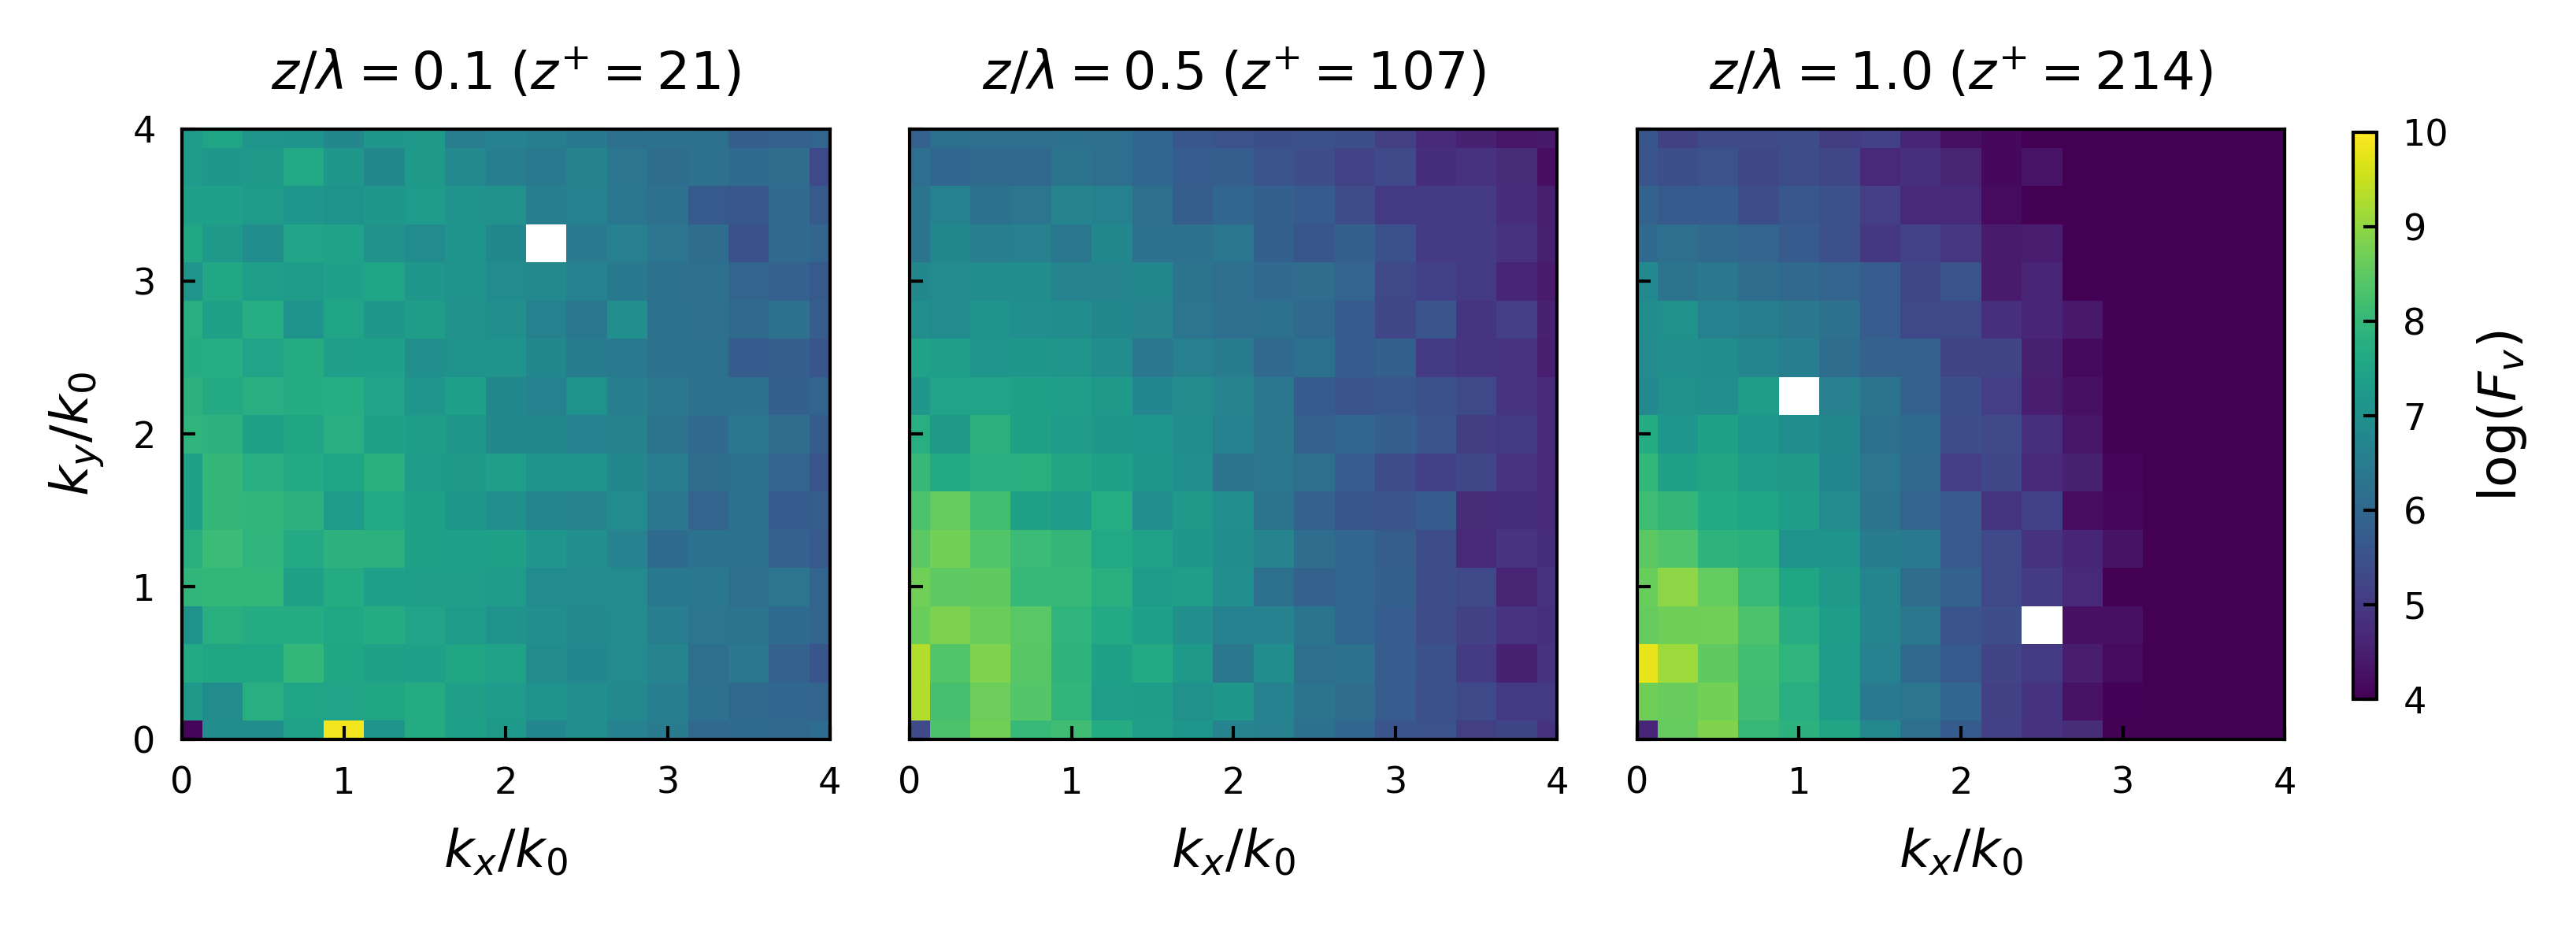

In [13]:
########## single plot ###########
# fig = plt.figure(figsize=[4,3]); ax = plt.gca()
# np.log(F).plot(x='freq_x', vmax=10, vmin=4, cbar_kwargs={'label':r'$\log(F_v)$'})
# ax.set_xlim([0,4]); ax.set_ylim([0,4])
# ax.set_title(r'$y=%.1f\delta$ (time-mean)' %(uyhat.y.isel(y=iy)))
# ax.set_xlabel(r'$k_x$'); ax.set_ylabel(r'$k_z$')

########## Three panels ##########
# note that data is with older name
fig, axes = plt.subplots(1, 3, sharey=True, figsize=[5,2])
hlist = [0.1, 0.5, 1]
N = F.sizes['t']
threshold = 0.3 # uncertainty tolerance

for i, ax in enumerate(axes):
    F_aver = abs(F).isel(y=i).mean(dim='t').values
    F_sigma = abs(F).isel(y=i).std(dim='t').values / N**0.5
    # If std/mean > threshold we set it to nan
    F_aver[F_sigma/F_aver > threshold] = np.nan
    a = ax.pcolormesh(F.freq_x*2*np.pi/4, F.freq_z*2*np.pi/4, np.log(F_aver), 
                      vmax=10, vmin=4, cmap='viridis')
    ax.set_xlim([0,4]); ax.set_ylim([0,4])
    ax.set_title('$z/\lambda=%.1f\; (z^{+}=%.0f)$' %(hlist[i],hlist[i]*wl/(2*np.pi-1)*720))
    ax.set_ylabel('')
    ax.set_xlabel(r'$k_x/k_0$')

cbar_ax = fig.add_axes([1, 0.25, 0.01, 0.6])  # Adjust as needed
cbar = plt.colorbar(a, cax=cbar_ax)
cbar.set_label(r'$\log(F_v)$')

axes[0].set_ylabel(r'$k_y/k_0$')
axes[0].set_yticks([0,1,2,3,4])
plt.tight_layout()
plt.savefig('../../plots/NWP_ZPG_CU4_zslices_spectrum.png', bbox_inches='tight')

17


/state/partition1/job-50796676/ipykernel_351885/3261447740.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


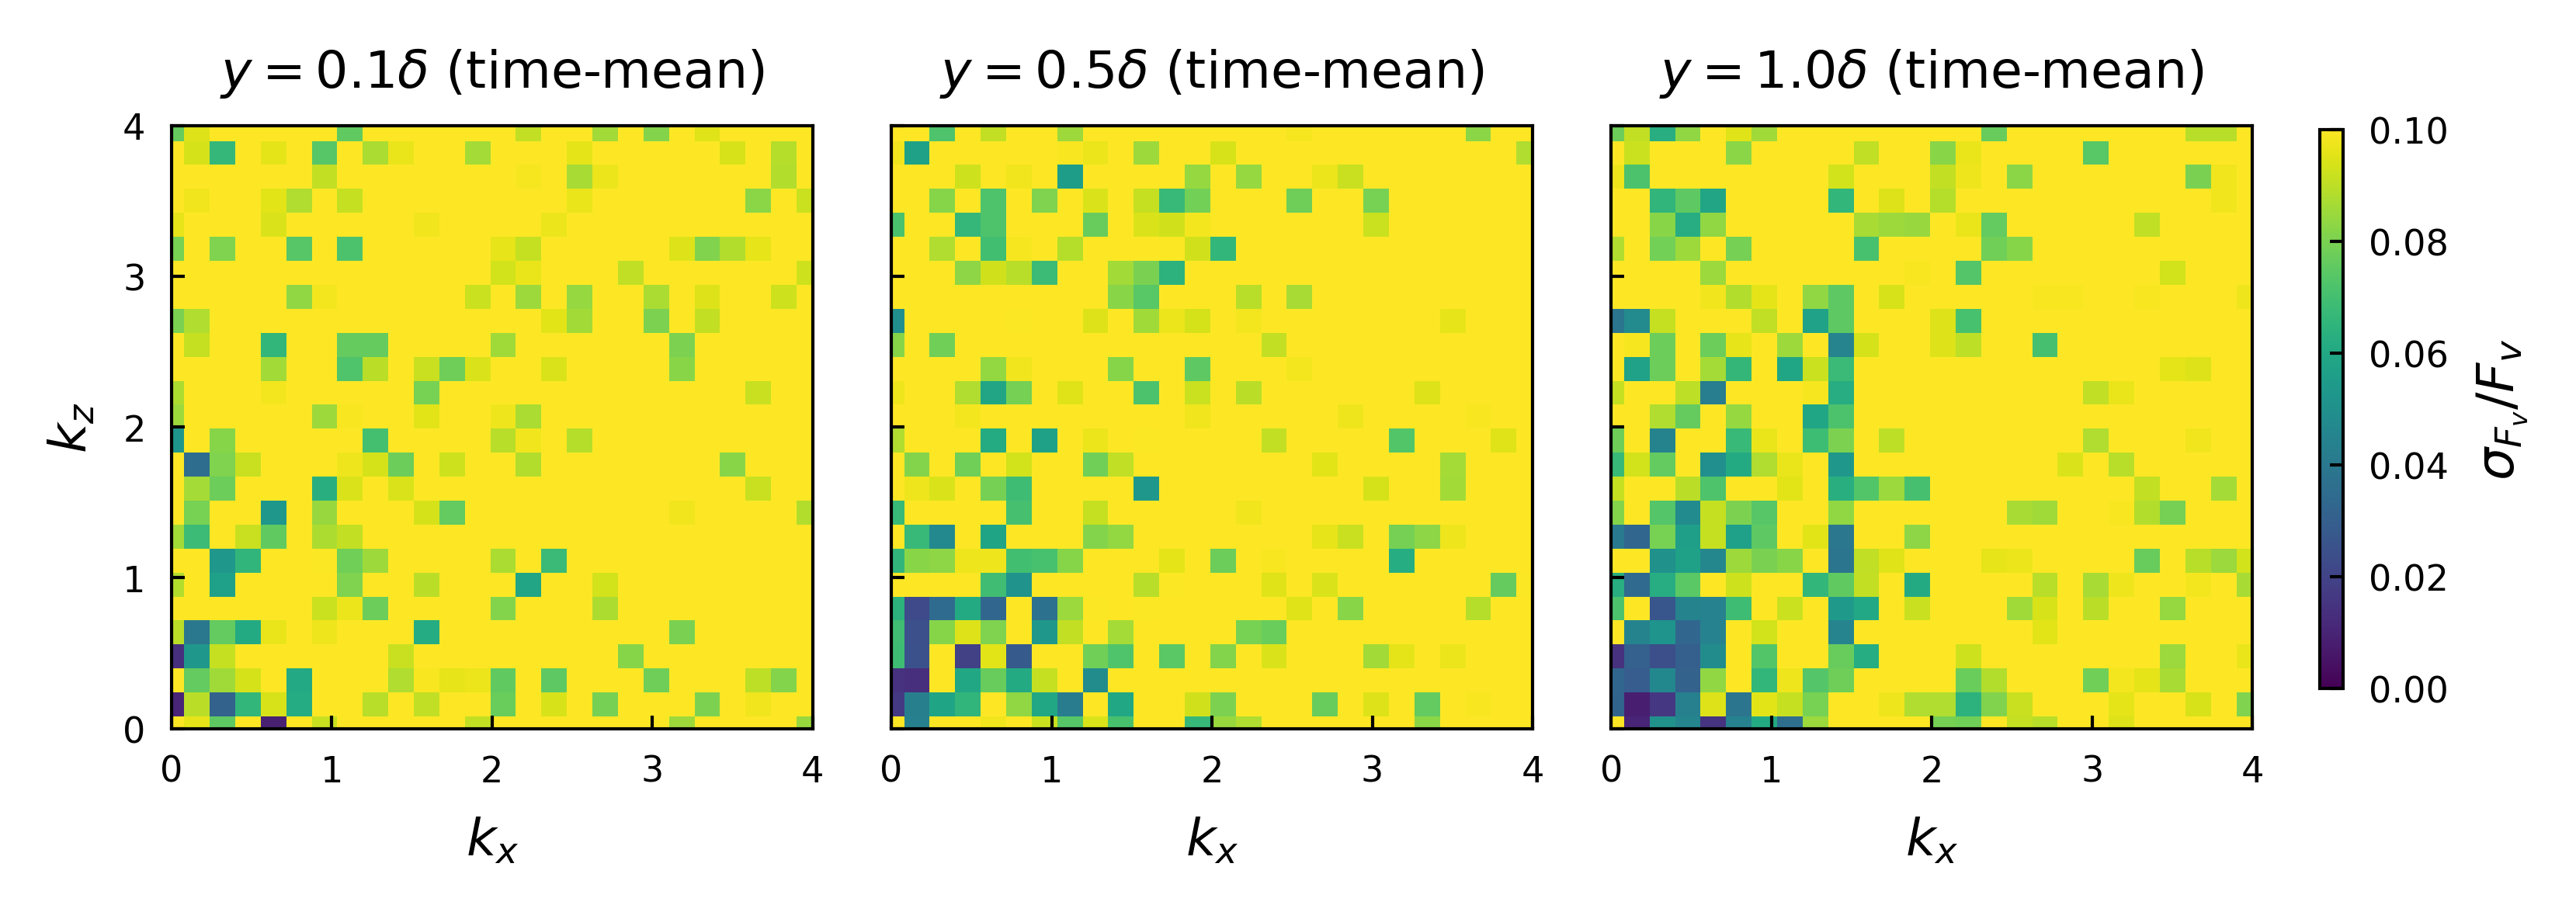

In [12]:
########## Three panels, standard deviation ##########
fig, axes = plt.subplots(1, 3, sharey=True, figsize=[5,2])
hlist = [0.1, 0.5, 1]

N = F.sizes['t']
print(N)

for i, ax in enumerate(axes):
    F_sigma = F.Fv.isel(y=i).std(dim='t') / N**0.5
    ratio = F_sigma / F.Fv.isel(y=i).mean(dim='t')
    a = ratio.plot(x='freq_x', ax=ax, vmax=0.1, vmin=0, add_colorbar=False)
    ax.set_xlim([0,4]); ax.set_ylim([0,4])
    ax.set_title(r'$y=%.1f\delta$ (time-mean)' %(F.y.isel(y=i)))
    ax.set_ylabel('')
    ax.set_xlabel(r'$k_x$')

cbar_ax = fig.add_axes([1, 0.25, 0.01, 0.6])  # Adjust as needed
cbar = plt.colorbar(a, cax=cbar_ax)
cbar.set_label(r'$\sigma_{F_v}/F_v$')

axes[0].set_ylabel(r'$k_z$')
axes[0].set_yticks([0,1,2,3,4])
plt.tight_layout()

#### Look at single snapshot spectrum (video generation)

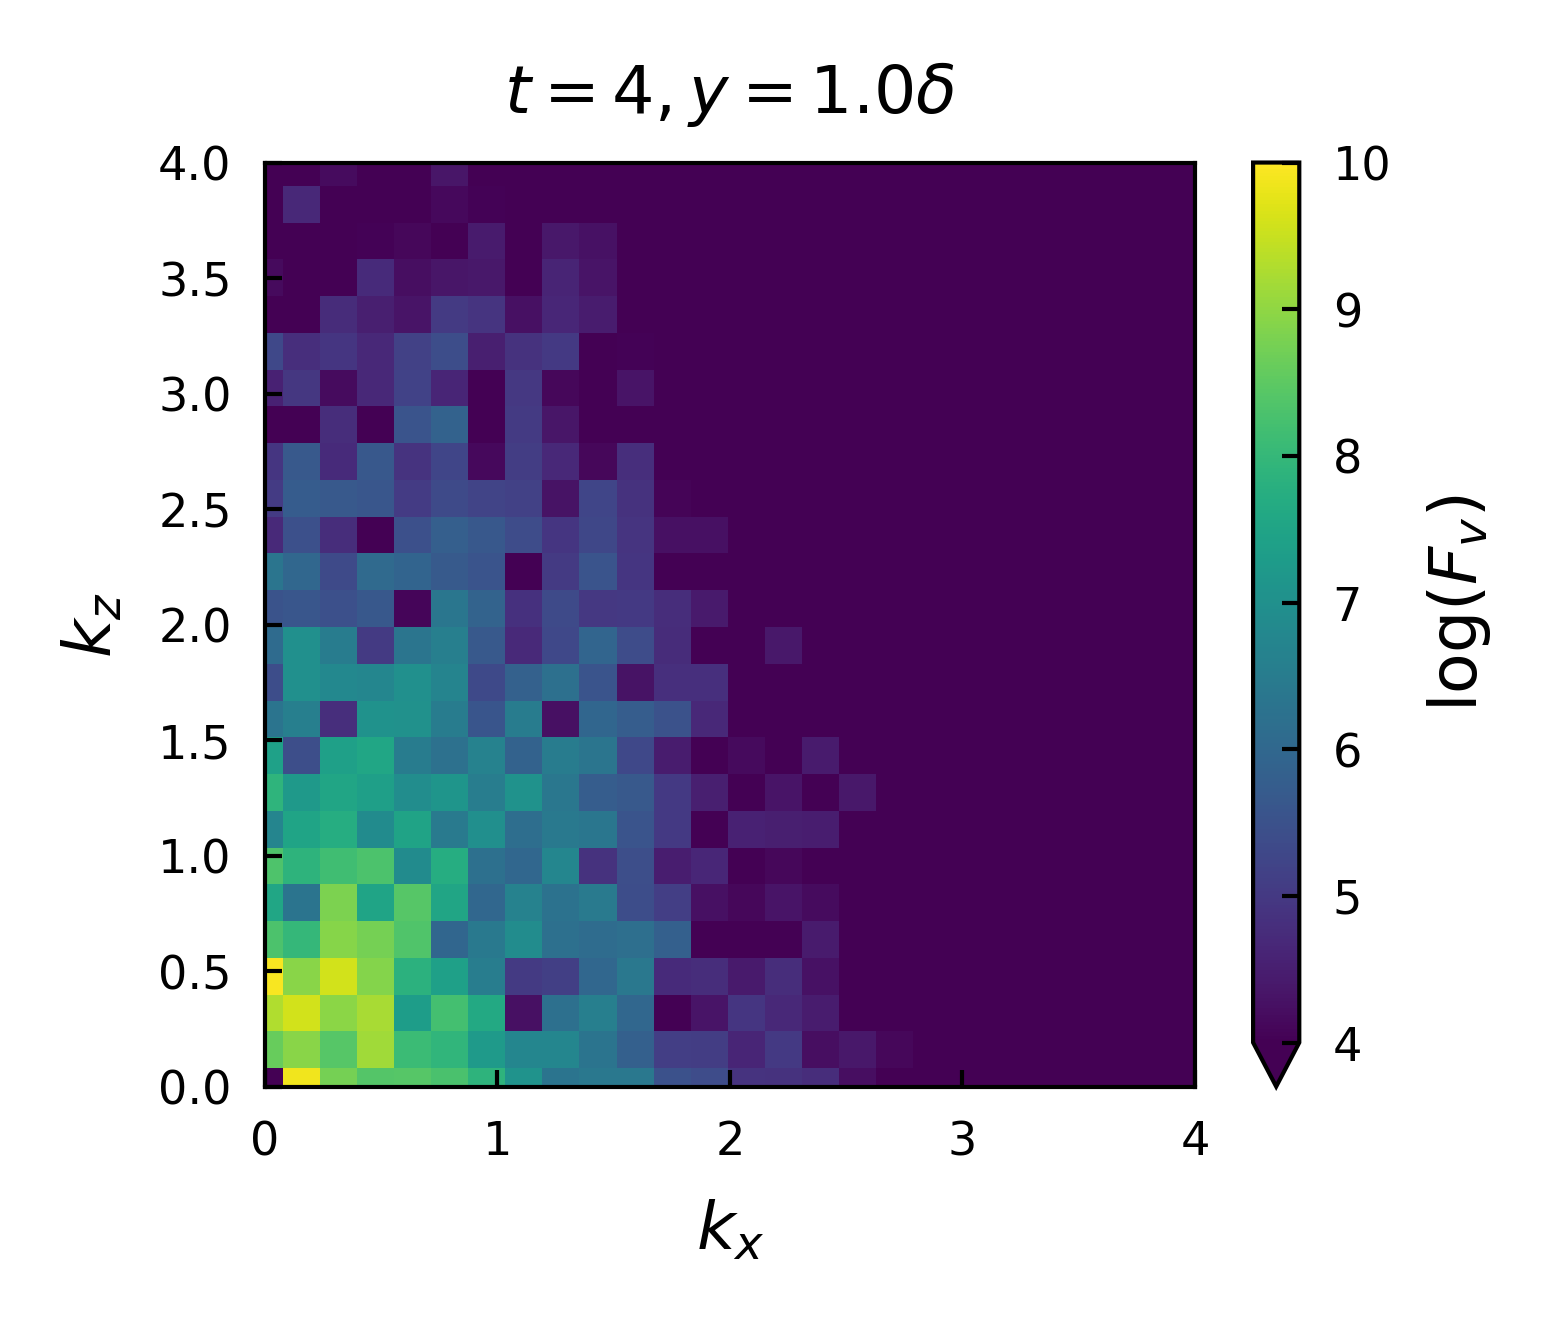

In [101]:
######### For the purpose of generating a video ############

fig = plt.figure(figsize=[2.5,2]) 
tstart = 40

PLOTPATH = '/home/jw8736/ctr/post-processing/plots/temp/'

for iy in range(0, uyhat.sizes['y']):
    for it in range(0, uyhat.sizes['t']):
        fig.clf(); ax = plt.gca()
        F = uyhat.isel(t=it, y=iy)
        np.log(abs(F)).plot(x='freq_x', vmax=10, vmin=4, cbar_kwargs={'label':r'$\log(F_v)$'})
        ax.set_xlim([0,4]); ax.set_ylim([0,4])
        ax.set_title(r'$t=%g, y=%.1f\delta$' %(uyhat.t.isel(t=it)-tstart, uyhat.y.isel(y=iy)))
        ax.set_xlabel(r'$k_x$'); ax.set_ylabel(r'$k_z$')
        fig.savefig(PLOTPATH + 'Fv_y%d_t%d.png' %(iy,it))

### TODO: glorified spectrum plot (log polar coord)

In [ ]:
file = DATAPATH + 'CU4/netcdf/field_eta_t44.nc'
ds = xr.open_dataset(file)

wl = 2*np.pi/4
ds['y'] = (ds['y'] - 1) / wl  

hlist = np.array([0.1, 0.5, 1])
uy = ds.uy.sel(y=hlist[0], method='nearest')

with ProgressBar():
    F = xrft.dft(uy, dim=['x','z']).compute()

/ext3/miniconda3/lib/python3.11/site-packages/xrft/xrft.py:248: FutureWarning: This function has been renamed and will disappear in the future. Please use `fft` instead
  warnings.warn(msg, FutureWarning)


In [28]:
F

<xarray.DataArray (freq_z: 512, freq_x: 512)>
array([[ 0.37664983+0.j        ,  0.18207702+0.08889596j,
         0.03452679-0.00977702j, ...,  0.02311391+0.14435296j,
         0.03452679+0.00977702j,  0.18207702-0.08889596j],
       [ 0.04615653+0.05940198j,  0.09737259-0.15049535j,
         0.1627398 -0.06132338j, ..., -0.19715675+0.03892141j,
        -0.14418843-0.03243318j, -0.14436319+0.01250467j],
       [ 0.02034314-0.0749902j , -0.10876786-0.05401566j,
        -0.01163291-0.03732432j, ...,  0.22758278+0.21485668j,
        -0.04067373-0.08838756j, -0.01305821+0.08487136j],
       ...,
       [-0.01940134+0.17601481j, -0.05146316-0.06461945j,
        -0.08978619+0.08060266j, ..., -0.01158267+0.10217731j,
        -0.12228545-0.06947958j,  0.13820738+0.17373018j],
       [ 0.02034314+0.0749902j , -0.01305821-0.08487136j,
        -0.04067373+0.08838756j, ...,  0.05243071+0.02743548j,
        -0.01163291+0.03732432j, -0.10876786+0.05401566j],
       [ 0.04615653-0.05940198j, -0.14436319-0.01250467j,
        -0.14418843+0.03243318j, ..., -0.27243754+0.11190987j,
         0.1627398 +0.06132338j,  0.09737259+0.15049535j]])
Coordinates:
    y        float64 0.1017
  * freq_x   (freq_x) float64 -40.74 -40.58 -40.43 -40.27 ... 40.27 40.43 40.58
  * freq_z   (freq_z) float64 -40.74 -40.58 -40.43 -40.27 ... 40.27 40.43 40.58

In [14]:
freq_x_2D = F.freq_x*abs(F)/abs(F)
freq_z_2D = F.freq_z*abs(F)/abs(F)
freq_2D = (freq_x_2D**2 + freq_z_2D**2)**0.5
freq_ref = 720/50000/(2*np.pi-1)
xi = np.log(freq_2D/freq_ref)
prefactor = freq_2D**2/xi
freq_x_log = xi*freq_x_2D/freq_2D
freq_z_log = xi*freq_z_2D/freq_2D

/ext3/miniconda3/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


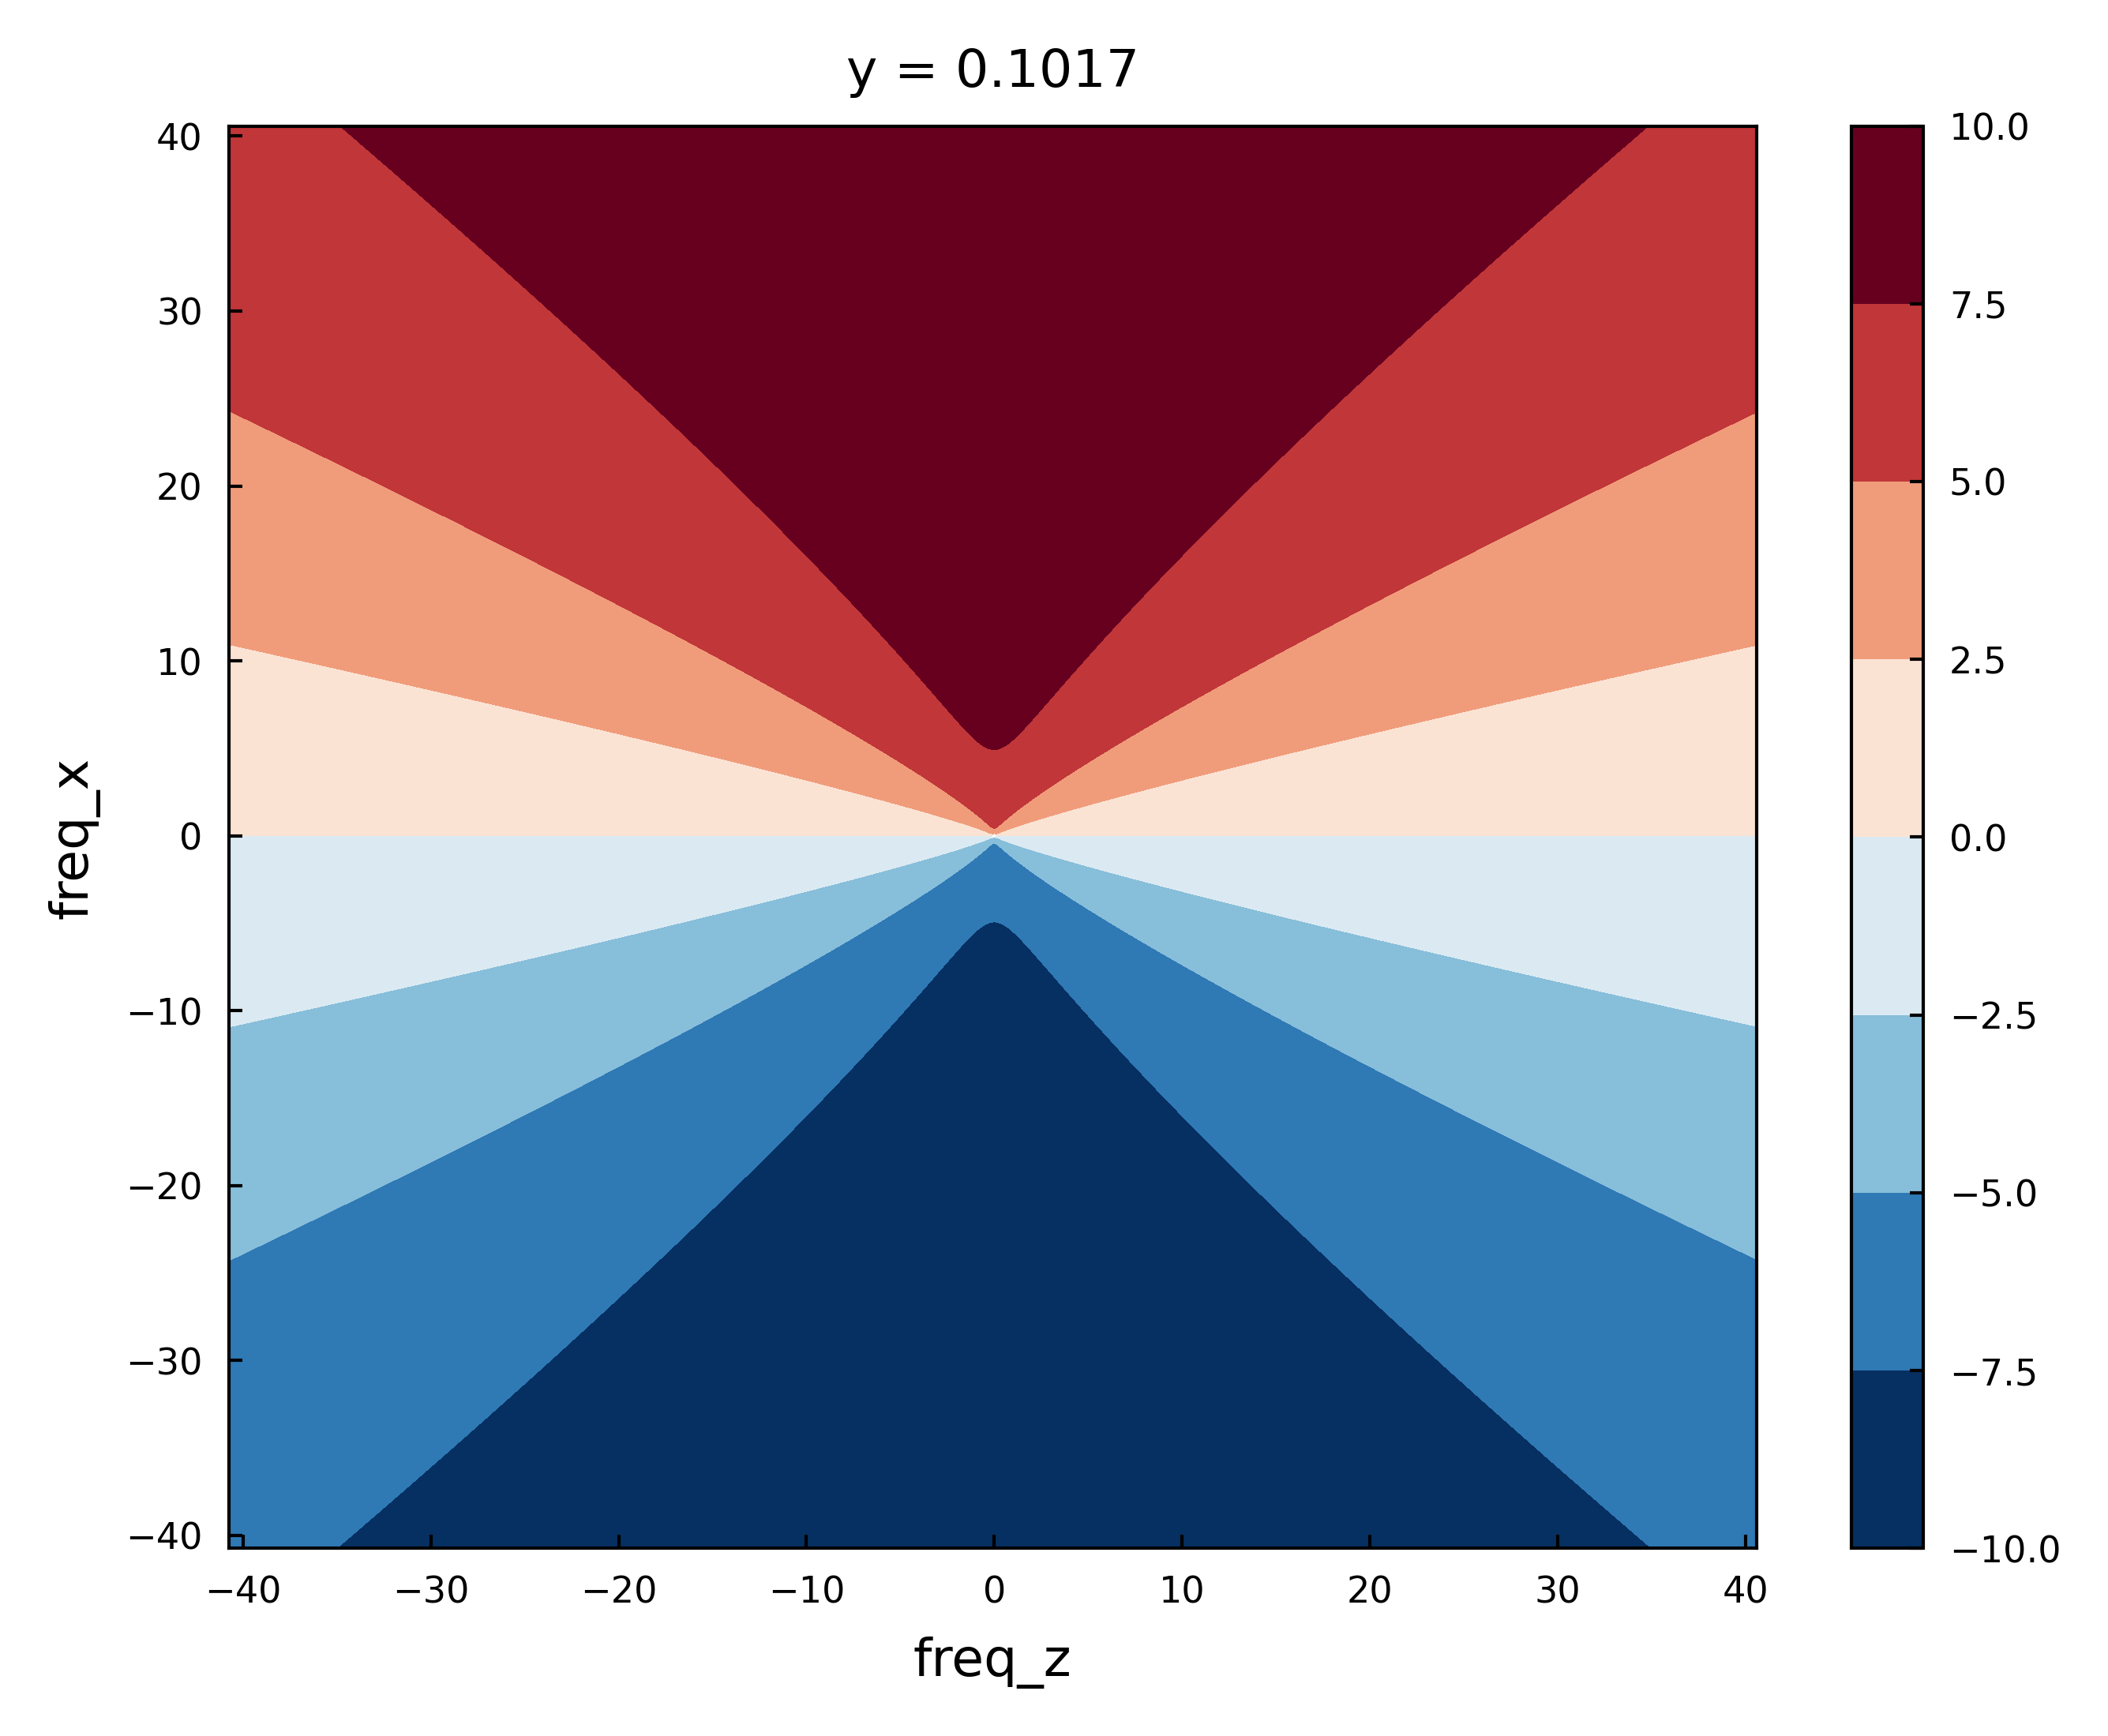

In [15]:
freq_x_log.plot.contourf(levels=10)

In [26]:
# Fnew = xr.Dataset(data_vars={'F':(['freq_x','freq_z'], F.values)}, 
#                   coords={'freq_x_log':(['freq_x','freq_z'], freq_x_log.values), 
#                           'freq_z_log':(['freq_x','freq_z'], freq_z_log.values)})
# Fnew = xr.DataArray(data=abs(F).values, dims=['freq_x', 'freq_z'],
#                     coords={'freq_x_log':(['freq_x','freq_z'], freq_x_log.values), 
#                           'freq_z_log':(['freq_x','freq_z'], freq_z_log.values)})

Fnew = xr.DataArray(data=abs(F).values, dims=['freq_x', 'freq_z'],
                    coords={'freq_x_log':(['freq_z','freq_x'], freq_x_2D.values), 
                          'freq_z_log':(['freq_z','freq_x'], freq_z_2D.values)})

(256.0, 300.0)

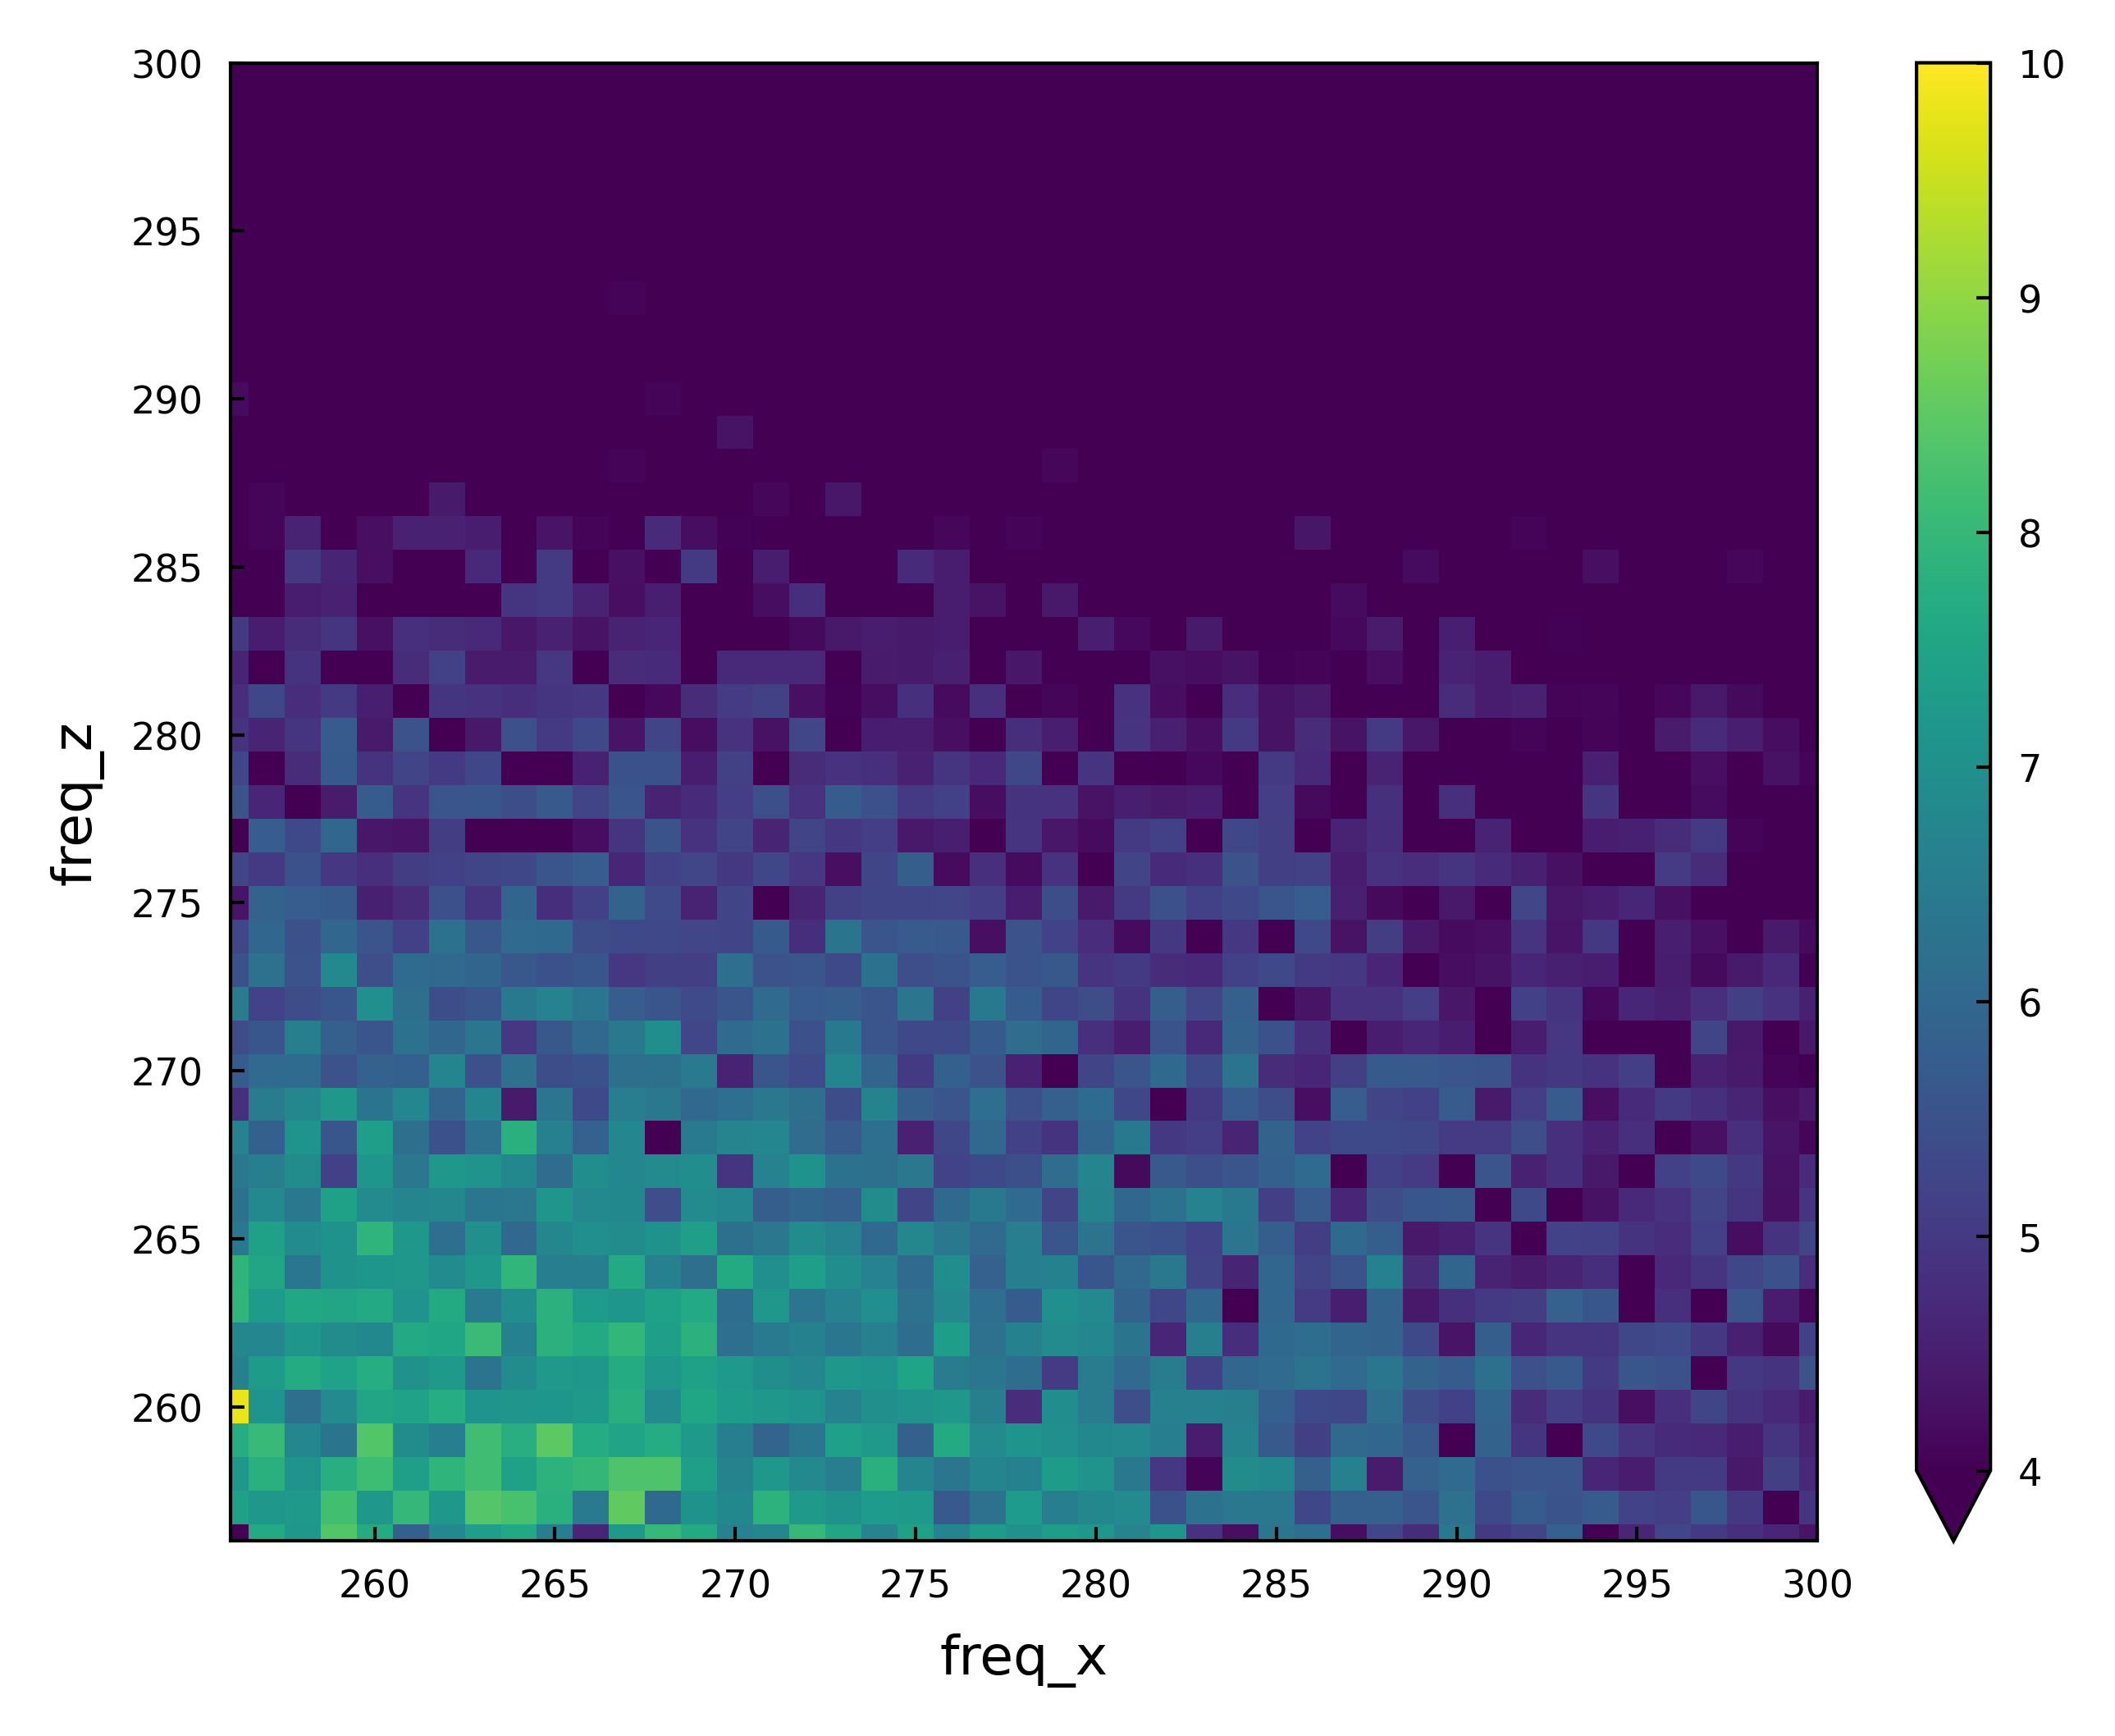

In [27]:
np.log(Fnew).plot(x='freq_x', vmax=10, vmin=4)
ax = plt.gca()
ax.set_xlim([256,300]); ax.set_ylim([256,300])